Neste notebook:
* Avaliação de usuários por bucket  
    * em média, e mediana, em quantos buckets os utilizadores estão.  
    * quantos usuários novos estão em cada bucket e quantos não ocorrem

Objetivo:
* explorar caracteristicas dos datasets que permitam
    * avaliar se o dataset é util para a análise  
    * escolher o número de buckets  

Vamos definir o numero de itens em cada bucket como 50k

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
import joblib
from data import ImplicitData
import pandas as pd 
import numpy as np 
from recommenders_implicit import ISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateAndStore # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout
from plot_utils import plot_n_users_per_bucket, plot_bucket_size
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

In [3]:
n_iter_bucket = 50E3

In [4]:
def get_bucket_map(eval_object:EvaluateAndStore):
    '''
    Create a dict that maps users (external id) to the buckets they are in (from 1 to last).
    '''
    user_bucket_map = {user:[] for user in eval_object.data.userset}
    for user in eval_object.data.userset:
        for i, bucket in enumerate( eval_object.holdouts ):
            if user in bucket.userset:
                user_bucket_map[user].append(i+1)
    return user_bucket_map

def median_user_presence_per_bucket(eval_object:EvaluateAndStore, user_bucket_map:dict):
    '''
    On median terms, on how many buckets a user is.
    '''
    presence_list = [len(user_bucket_map[user]) for user in eval_object.data.userset]
    return np.median( presence_list )

def plot_bucket_size(eval_object, dataset_name, filename=None):
    bucket_size = pd.Series( [bucket.size for bucket in eval_object.holdouts] )
    bucket_size = bucket_size.reset_index()
    bucket_size.columns = ['Bucket', 'Size']
    bucket_size['Bucket'] = bucket_size['Bucket']+1
    plt.figure(figsize=(10,5))
    sns.barplot(x='Bucket', y='Size', data=bucket_size, color='b')
    # sns.lineplot(data=np.repeat(n_users, n_users_bucket.shape[0]), label='total users', color='orange')
    plt.title(f'Bucket size - {dataset_name}')
    if filename:
        plt.savefig(f'images/user_bucket_analysis/{filename}')

# Store buckets

___
### Palco 2010

In [5]:
# importa dataset 'palco playlists'
data = pd.read_csv("../datasets/palco_2010.tsv","\t")

In [6]:
num_factors = 200
num_iter = 6
learn_rate = 0.35
regularization = 0.5
num_nodes = 8

In [7]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte.
# recebe listas
# stream = ImplicitData(data['UserID'].to_list(), data['ItemID'].to_list())
stream = ImplicitData(data['user_id'], data['track_id'])

empty_stream = ImplicitData([], [])

In [8]:
# O modelo não pode conter o stream, deve ser iniciado com uma lista vazia
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [9]:
# criamos instancia de EvaluateAndStore para criar holdouts com o método EvaluateAndStore
n_holdouts = int( data.shape[0]/n_iter_bucket )
eval_palco = EvaluateAndStore(model=model, data=stream, n_holdouts=n_holdouts, metrics=["Recall@N"], N_recommendations=20, seed=42)

In [10]:
# interações de 0 a 100 são usadas para pre treino. 
# count define numero de interações a serem usadas.
# holdouts e checkpoints são 
# store_only - somente guarda holdouts, não faz avaliação prequencial.
# default_user - Somente usado quando store_only = False durante avaliação prequencial.
_ = eval_palco.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True) # 17 min

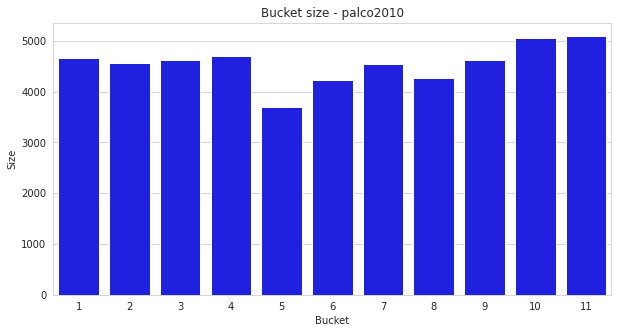

In [19]:
plot_bucket_size(eval_object=eval_palco, dataset_name='palco2010', filename='palco2010_bucket_size.png')

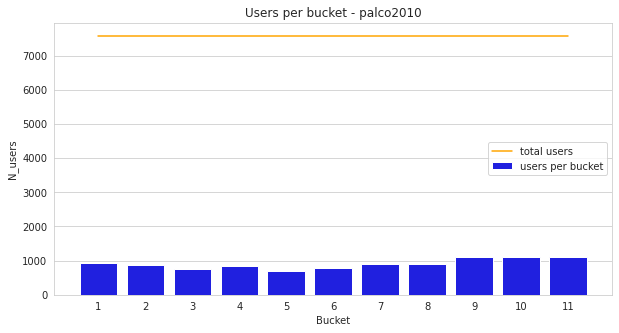

In [14]:
plot_n_users_per_bucket(eval_object=eval_palco, dataset_name='palco2010', filename='palco2010_user_per_bucket.png')

In [ ]:
palco2010_ubm = get_bucket_map(eval_object=eval_palco)
palco2010_median_user_presence = median_user_presence_per_bucket(eval_object=eval_palco, user_bucket_map=palco2010_ubm)
palco2010_median_user_presence

1.0

In [ ]:
joblib.dump(palco2010_ubm, 'output/joblib_bucket_info_dump/palco2010_ubm', compress=True)

['output/joblib_eval_objects_dump/palco2010_ubm']

___
### Movielens

In [5]:
# importa dataset 'movielensm1'
data = pd.read_csv("../datasets/ml1m_gte5.csv","\t")

In [6]:
num_factors = 160
num_iter = 8
learn_rate = 0.1
regularization = 0.4
num_nodes = 8

In [7]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte.
# recebe listas
# stream = ImplicitData(data['UserID'].to_list(), data['ItemID'].to_list())
stream = ImplicitData(data['UserID'], data['ItemID'])

empty_stream = ImplicitData([], [])

In [8]:
# O modelo não pode conter o stream, deve ser iniciado com uma lista vazia
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [9]:
# criamos instancia de EvaluateAndStore para criar holdouts com o método EvaluateAndStore
n_holdouts = int( data.shape[0]/n_iter_bucket )
eval_movielens = EvaluateAndStore(model=model, data=stream, n_holdouts=n_holdouts, metrics=["Recall@N"], N_recommendations=20, seed=42)

In [10]:
# interações de 0 a 100 são usadas para pre treino. 
# count define numero de interações a serem usadas.
# holdouts e checkpoints são 
# store_only - somente guarda holdouts, não faz avaliação prequencial.
# default_user - Somente usado quando store_only = False durante avaliação prequencial.
_ = eval_movielens.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True) # 1:40 min

KeyboardInterrupt: 

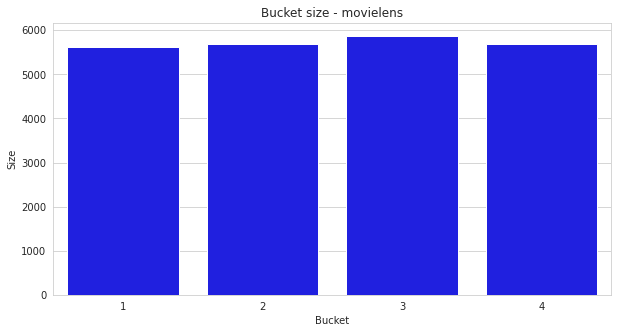

In [ ]:
plot_bucket_size(eval_object=eval_movielens, dataset_name='movielens', filename='movielens_user_per_bucket.png')

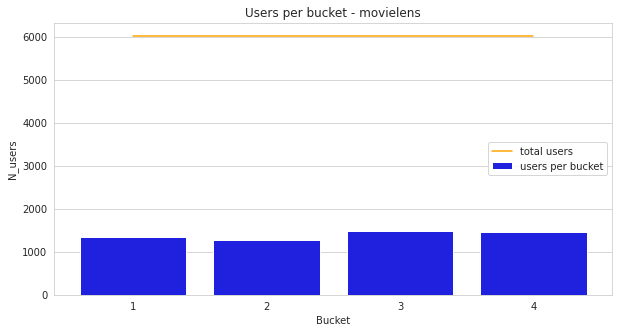

In [ ]:
plot_n_users_per_bucket(eval_object=eval_movielens, dataset_name='movielens', filename='movielens_user_per_bucket.png')

In [ ]:
movielens_ubm = get_bucket_map(eval_object=eval_movielens)
movielens_median_user_presence = median_user_presence_per_bucket(eval_object=eval_movielens, user_bucket_map=movielens_ubm)
movielens_median_user_presence

1.0

In [ ]:
eval_movielens.data.GetUserItems(1, internal=False)

array([1270, 1022, 1836, 2804, 1193, 1961, 2028, 3105, 1035,  150, 1028,
       1287, 1029,  527,  595,    1, 2355,   48])

In [ ]:
joblib.dump(movielens_ubm, 'output/joblib_bucket_info_dump/movielens_ubm', compress=True)

['output/joblib_bucket_info_dump/movielens_ubm']

In [ ]:
movielens_ubm

{1: [],
 2: [4],
 3: [4],
 4: [4],
 5: [4],
 6: [],
 7: [4],
 8: [4],
 9: [4],
 10: [4],
 11: [4],
 12: [4],
 13: [4],
 14: [],
 15: [],
 16: [],
 17: [4],
 18: [4],
 19: [4],
 20: [4],
 21: [4],
 22: [4],
 23: [4],
 24: [4],
 25: [4],
 26: [4],
 27: [4],
 28: [4],
 29: [4],
 30: [],
 31: [4],
 32: [4],
 33: [4],
 34: [4],
 35: [4],
 36: [4],
 37: [4],
 38: [],
 39: [4],
 40: [4],
 41: [4],
 42: [4],
 43: [],
 44: [4],
 45: [],
 46: [4],
 47: [],
 48: [4],
 49: [4],
 50: [],
 51: [4],
 52: [4],
 53: [4],
 54: [],
 55: [4],
 56: [],
 57: [4],
 58: [4],
 59: [],
 60: [4],
 62: [4],
 63: [4],
 64: [4],
 65: [4],
 66: [],
 67: [4],
 68: [4],
 69: [4],
 70: [4],
 71: [4],
 72: [4],
 73: [4],
 74: [4],
 75: [4],
 76: [4],
 77: [4],
 78: [4],
 79: [],
 80: [4],
 81: [4],
 82: [4],
 83: [4],
 84: [4],
 85: [4],
 86: [4],
 87: [4],
 88: [4],
 89: [],
 90: [4],
 91: [4],
 92: [4],
 93: [4],
 94: [],
 95: [4],
 96: [4],
 97: [4],
 98: [4],
 99: [4],
 100: [],
 101: [4],
 102: [4],
 103: [4],
 104

___

In [ ]:
def get_bucket_map(eval_object:EvaluateAndStore):
    '''
    Create a dict that maps users (external id) to the buckets they are in (from 1 to last).
    '''
    user_bucket_map = {user:[] for user in eval_object.data.userset}
    for user in eval_object.data.userset:
        for i, bucket in enumerate( eval_object.holdouts ):
            if user in bucket.userset:
                user_bucket_map[user].append(i+1)
    return user_bucket_map

def median_user_presence_per_bucket(eval_object:EvaluateAndStore, user_bucket_map:dict):
    '''
    On median terms, on how many buckets a user is.
    '''
    presence_list = [len(user_bucket_map[user]) for user in eval_object.data.userset]
    return np.median( presence_list )

In [44]:
test_bm = {user:[] for user in eval_movielens.data.userset}
for user in eval_movielens.data.userset:
    for i, bucket in enumerate( eval_movielens.holdouts ):
        if user in bucket.userset:
            test_bm[user].append(i+1)

In [41]:
movielens_ubm

{1: [],
 2: [4],
 3: [4],
 4: [4],
 5: [4],
 6: [],
 7: [4],
 8: [4],
 9: [4],
 10: [4],
 11: [4],
 12: [4],
 13: [4],
 14: [],
 15: [],
 16: [],
 17: [4],
 18: [4],
 19: [4],
 20: [4],
 21: [4],
 22: [4],
 23: [4],
 24: [4],
 25: [4],
 26: [4],
 27: [4],
 28: [4],
 29: [4],
 30: [],
 31: [4],
 32: [4],
 33: [4],
 34: [4],
 35: [4],
 36: [4],
 37: [4],
 38: [],
 39: [4],
 40: [4],
 41: [4],
 42: [4],
 43: [],
 44: [4],
 45: [],
 46: [4],
 47: [],
 48: [4],
 49: [4],
 50: [],
 51: [4],
 52: [4],
 53: [4],
 54: [],
 55: [4],
 56: [],
 57: [4],
 58: [4],
 59: [],
 60: [4],
 62: [4],
 63: [4],
 64: [4],
 65: [4],
 66: [],
 67: [4],
 68: [4],
 69: [4],
 70: [4],
 71: [4],
 72: [4],
 73: [4],
 74: [4],
 75: [4],
 76: [4],
 77: [4],
 78: [4],
 79: [],
 80: [4],
 81: [4],
 82: [4],
 83: [4],
 84: [4],
 85: [4],
 86: [4],
 87: [4],
 88: [4],
 89: [],
 90: [4],
 91: [4],
 92: [4],
 93: [4],
 94: [],
 95: [4],
 96: [4],
 97: [4],
 98: [4],
 99: [4],
 100: [],
 101: [4],
 102: [4],
 103: [4],
 104

___
### Ymusic

In [ ]:
data = pd.read_csv("../datasets/ymusic_gte90_6kusers.tsv","\t")
stream = ImplicitData(data['user_id'],data['item_id'])
empty_stream = ImplicitData([], [])

In [ ]:
num_factors = 200
num_iter = 9
learn_rate = 0.25
regularization = 0.45
num_nodes = 16

In [ ]:
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [ ]:
n_holdouts = int( data.shape[0]/n_iter_bucket )
eval_ymusic = EvaluateAndStore(model=model, data=stream, n_holdouts=n_holdouts, metrics = ["Recall@N"], N_recommendations=20, seed=42)

In [ ]:
_=eval_ymusic.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True) # 42 min

In [ ]:
joblib.dump(eval_ymusic, 'output/joblib_bucket_info_dump/eval_ymusic', compress=True)

___
### Lastfm

In [ ]:
# importa dataset 'palco playlists'
data = pd.read_csv("../datasets/lastfm_50u.tsv","\t")

# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte.
# recebe listas
stream = ImplicitData(data['user_id'], data['item_id'])

empty_stream = ImplicitData([], [])

In [ ]:
num_factors = 160
num_iter = 4
learn_rate = 0.5
regularization = 0.4
num_nodes = 8

In [ ]:
# O modelo não pode conter o stream, deve ser iniciado com uma lista vazia
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [ ]:
n_holdouts = int( data.shape[0]/n_iter_bucket )
eval_lastfm = EvaluateAndStore(model=model, data=stream, n_holdouts=n_holdouts, metrics = ["Recall@N"], N_recommendations=20, seed=42)

In [ ]:
_=eval_lastfm.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True) # 441 min

In [ ]:
joblib.dump(eval_lastfm, 'output/joblib_bucket_info_dump/eval_lastfm', compress=True)

# Evaluation

In [ ]:
# def plot_n_users_per_bucket(eval_object:EvaluateAndStore, dataset_name:str, filename:str=None):
#     n_users = len( eval_object.data.userset )
#     n_users_bucket = pd.Series( [len( bucket.userset ) for bucket in eval_object.holdouts] )
#     n_users_bucket = n_users_bucket.reset_index()
#     n_users_bucket.columns = ['Bucket', 'N_users']
#     n_users_bucket['Bucket'] = n_users_bucket['Bucket']+1
#     plt.figure(figsize=(10,5))
#     sns.barplot(x='Bucket', y='N_users', data=n_users_bucket, color='b', label='users per bucket')
#     sns.lineplot(data=np.repeat(n_users, n_users_bucket.shape[0]), label='total users', color='orange')
#     plt.title(f'Users per bucket - {dataset_name}');
#     if filename:
#         plt.savefig(f'images/user_bucket_analysis/{filename}')

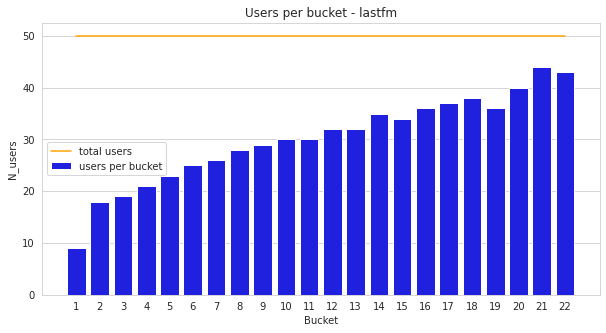

14.0

In [97]:
[bucket.userset for bucket in eval_lastfm.holdouts]

[array(['user_000174', 'user_000337', 'user_000407', 'user_000707',
        'user_000709', 'user_000751', 'user_000957', 'user_000984',
        'user_000986'], dtype='<U11'),
 array(['user_000019', 'user_000033', 'user_000174', 'user_000249',
        'user_000262', 'user_000267', 'user_000337', 'user_000390',
        'user_000407', 'user_000707', 'user_000709', 'user_000751',
        'user_000807', 'user_000882', 'user_000912', 'user_000957',
        'user_000984', 'user_000986'], dtype='<U11'),
 array(['user_000019', 'user_000033', 'user_000174', 'user_000249',
        'user_000262', 'user_000337', 'user_000374', 'user_000390',
        'user_000407', 'user_000707', 'user_000709', 'user_000751',
        'user_000767', 'user_000807', 'user_000882', 'user_000912',
        'user_000957', 'user_000984', 'user_000986'], dtype='<U11'),
 array(['user_000019', 'user_000033', 'user_000174', 'user_000249',
        'user_000262', 'user_000267', 'user_000330', 'user_000337',
        'user_000374',

In [43]:
plt.figure(figsize=(10,5))
sns.barplot(x='Bucket', y='N_users', data=n_users_bucket, color='b', label='users per bucket')
sns.lineplot(data=np.repeat(n_users, n_users_bucket.shape[0]), label='total users', color='orange');

3784